In [3]:
#!/usr/bin/env python3
"""
Model Comparison Test Suite for Intent Interpretation

This script compares different OpenAI models for their efficiency and accuracy
in interpreting user intents from text responses, specifically for fall detection scenarios.
"""

import logging
import json
import argparse
import os
import time
import statistics
from typing import Dict, List, Tuple, Literal, Any
from datetime import datetime
from prettytable import PrettyTable

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("ModelComparisonTest")

# Check for required dependencies
def check_requirements():
    """Check if required libraries are installed"""
    requirements = {
        'openai': 'pip install openai',
        'prettytable': 'pip install prettytable'
    }
    
    missing = []
    for lib, install_cmd in requirements.items():
        try:
            importlib.import_module(lib)
        except ImportError:
            missing.append((lib, install_cmd))
    
    if missing:
        logger.error("Missing required dependencies:")
        for lib, cmd in missing:
            logger.error(f"  - {lib}: Install with '{cmd}'")
        return False
    return True

# Import libraries after checking
import openai
from prettytable import PrettyTable

# Default to environment variable, can be overridden via command line
OPENAI_API_KEY = ""

# List of models to test
MODELS_TO_TEST = [
    "gpt-3.5-turbo",
    "gpt-4o",
    "gpt-4o-mini",
    "gpt-4-turbo"
]

def interpret_intent(
    text: str,
    model: str,
    api_key: str = OPENAI_API_KEY
) -> Tuple[Literal['ok', 'not_ok', 'unclear'], float, bool, str]:
    """
    Interpret the intent of the text using a specified OpenAI model.
    Returns the intent classification, the time taken for the API call,
    whether the response format was valid, and the raw response text.
    
    Args:
        text: The text to interpret, typically a response to "Did you fall?"
        model: The OpenAI model to use
        api_key: OpenAI API key
        
    Returns:
        Tuple of (intent, response_time, format_valid, raw_response) where:
            - intent is one of: 'ok', 'not_ok', 'unclear'
            - response_time is the time taken for the API call in seconds
            - format_valid is a boolean indicating if the response format was valid
            - raw_response is the raw text response from the model
    """
    # Set API key
    if api_key:
        openai.api_key = api_key
    elif os.environ.get("OPENAI_API_KEY"):
        openai.api_key = os.environ.get("OPENAI_API_KEY")
    else:
        logger.error("OpenAI API key not set. Please provide via parameter or OPENAI_API_KEY env var")
        return "unclear", 0.0, False, "No API key provided"
    
    logger.debug(f"Interpreting intent for text: '{text}' using model: {model}")
    
    start_time = time.time()
    try:
        # Create the prompt with instructions for JSON structure
        prompt = f"""
        An elderly person was asked: "Did you fall?".
        They responded: "{text}"
        
        Classify the intent into one of:
        - 'ok' (they explicitly state they did NOT fall or are fine, regardless of tone or additional words)
        - 'not_ok' (they explicitly state they DID fall or need help)
        - 'unclear' (ambiguous or unrelated response)
        
        Examples:
        - "No, I'm fine" -> ok
        - "No, I didn't fall" -> ok
        - "No, go away" -> ok
        - "Yes, I fell" -> not_ok
        - "Help me" -> not_ok
        - "What?" -> unclear
        - "I'm hungry" -> unclear
        
        Respond with a JSON object that has a single field 'intent' with a value of either 'ok', 'not_ok', or 'unclear'.
        Example response: {{"intent": "ok"}}
        """
        
        # Get the response with structured format
        response = openai.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            response_format={"type": "json_object"}
        )
        
        # Calculate response time
        response_time = time.time() - start_time
        
        # Get the raw response
        raw_response = response.choices[0].message.content
        
        # Validate response format
        format_valid = True
        intent = "unclear"
        
        try:
            # Attempt to parse the JSON
            parsed_result = json.loads(raw_response)
            
            # Check if the 'intent' field exists
            if 'intent' not in parsed_result:
                logger.warning(f"Response missing 'intent' field: {raw_response}")
                format_valid = False
            else:
                # Check if the intent value is valid
                intent = parsed_result["intent"]
                if intent not in ["ok", "not_ok", "unclear"]:
                    logger.warning(f"Invalid intent value: {intent}")
                    format_valid = False
                    intent = "unclear"  # Default to unclear for invalid values
                    
        except json.JSONDecodeError:
            logger.warning(f"Invalid JSON response: {raw_response}")
            format_valid = False
        
        logger.debug(f"Detected intent: {intent} in {response_time:.2f}s, format valid: {format_valid}")
        return intent, response_time, format_valid, raw_response
    except Exception as e:
        response_time = time.time() - start_time
        logger.error(f"Error interpreting intent with model {model}: {e}")
        return "unclear", response_time, False, str(e)

class TestResult:
    """Class to store test results for reporting"""
    def __init__(self, model: str):
        self.model = model
        self.correct_count = 0
        self.total_count = 0
        self.response_times = []
        self.failures = []  # List to store details of failed tests
        self.format_errors = []  # List to store format compliance errors
        
    @property
    def accuracy(self) -> float:
        """Calculate accuracy as percentage"""
        if self.total_count == 0:
            return 0.0
        return (self.correct_count / self.total_count) * 100
        
    @property
    def format_compliance(self) -> float:
        """Calculate format compliance as percentage"""
        if self.total_count == 0:
            return 0.0
        format_error_count = len(self.format_errors)
        return ((self.total_count - format_error_count) / self.total_count) * 100
    
    @property
    def avg_response_time(self) -> float:
        """Calculate average response time"""
        if not self.response_times:
            return 0.0
        return statistics.mean(self.response_times)
    
    @property
    def median_response_time(self) -> float:
        """Calculate median response time"""
        if not self.response_times:
            return 0.0
        return statistics.median(self.response_times)
    
    @property
    def min_response_time(self) -> float:
        """Get minimum response time"""
        if not self.response_times:
            return 0.0
        return min(self.response_times)
    
    @property
    def max_response_time(self) -> float:
        """Get maximum response time"""
        if not self.response_times:
            return 0.0
        return max(self.response_times)
    
    @property
    def total_time(self) -> float:
        """Get total time taken for all tests"""
        return sum(self.response_times)


def get_test_cases() -> List[Tuple[str, Literal['ok', 'not_ok', 'unclear']]]:
    """Return an extended list of test cases with expected results"""
    return [
        # OK responses
        ("No, I didn't fall", "ok"),
        ("I'm fine", "ok"),
        ("No, leave me alone", "ok"),
        ("I'm okay", "ok"),
        ("No, I'm good", "ok"),
        ("I didn't fall", "ok"),
        ("No need to worry", "ok"),
        ("No, just sitting down", "ok"),
        ("No fall here", "ok"),
        ("I'm perfectly fine", "ok"),
        ("No, I'm just resting", "ok"),
        ("Everything is fine", "ok"),
        ("I'm all good", "ok"),
        ("No problems here", "ok"),
        ("Standing strong", "ok"),
        ("No, absolutely not", "ok"),
        ("I'm still on my feet", "ok"),
        ("No, thanks for checking", "ok"),
        ("I’m good, didn’t fall", "ok"),
        ("Not at all, I’m steady", "ok"),
        ("All is well", "ok"),
        ("Nope, no fall", "ok"),
        ("Everything’s under control", "ok"),
        ("Safe and sound", "ok"),
        ("Didn’t fall, just stretching", "ok"),
        ("Just resting, didn’t fall", "ok"),

        # NOT_OK responses
        ("Yes, I fell down", "not_ok"),
        ("Help me please", "not_ok"),
        ("I can't get up", "not_ok"),
        ("I fell and hurt my hip", "not_ok"),
        ("Yes, I need assistance", "not_ok"),
        ("I've fallen", "not_ok"),
        ("I slipped and fell", "not_ok"),
        ("Yes, and it hurts", "not_ok"),
        ("I need help getting up", "not_ok"),
        ("I'm stuck on the floor", "not_ok"),
        ("I collapsed", "not_ok"),
        ("I'm injured", "not_ok"),
        ("Call for help", "not_ok"),
        ("Yes, call 911", "not_ok"),
        ("I'm in pain after falling", "not_ok"),
        ("I fell down the stairs", "not_ok"),
        ("I'm bleeding", "not_ok"),
        ("Please assist me", "not_ok"),
        ("Emergency, I fell", "not_ok"),
        ("I hit my head", "not_ok"),
        ("Something’s wrong, I fell", "not_ok"),
        ("Please, I can’t stand up", "not_ok"),
        ("Help, I've fallen", "not_ok"),
        ("Yes, I fell badly", "not_ok"),
        ("Pain in my leg, I fell", "not_ok"),

        # UNCLEAR responses
        ("What did you say?", "unclear"),
        ("I'm watching TV", "unclear"),
        ("It's time for dinner", "unclear"),
        ("Where are my glasses?", "unclear"),
        ("I'm sleepy", "unclear"),
        ("Who are you?", "unclear"),
        ("What fall?", "unclear"),
        ("The weather is nice today", "unclear"),
        ("I don't understand", "unclear"),
        ("Can you call my daughter?", "unclear"),
        ("What time is it?", "unclear"),
        ("I'm hungry", "unclear"),
        ("Is it time for my medicine?", "unclear"),
        ("Let me think about that", "unclear"),
        ("Why do you ask?", "unclear"),
        ("Maybe", "unclear"),
        ("Come back later", "unclear"),
        ("Turn on the light", "unclear"),
        ("Just relaxing here", "unclear"),
        ("You startled me", "unclear"),
        ("Not now", "unclear"),
        ("Can you repeat that?", "unclear"),
        ("What’s going on?", "unclear"),
        ("Just got home", "unclear"),
        ("Leave me alone", "unclear"),
    ]

def run_model_comparison(models: List[str] = None, max_tests: int = None) -> Dict[str, TestResult]:
    """
    Run test cases against multiple models and collect performance data
    
    Args:
        models: List of model names to test (defaults to MODELS_TO_TEST)
        max_tests: Maximum number of tests to run per model (defaults to all)
        
    Returns:
        Dictionary mapping model names to TestResult objects
    """
    if models is None:
        models = MODELS_TO_TEST
    
    test_cases = get_test_cases()
    if max_tests is not None:
        test_cases = test_cases[:max_tests]
    
    results = {}
    
    for model in models:
        logger.info(f"Testing model: {model}")
        test_result = TestResult(model)
        results[model] = test_result
        
        for i, (text, expected) in enumerate(test_cases):
            logger.info(f"[{i+1}/{len(test_cases)}] Testing: '{text}' (Expected: {expected})")
            
            # Run the test
            intent, response_time, format_valid, raw_response = interpret_intent(text, model)
            test_result.response_times.append(response_time)
            test_result.total_count += 1
            
            # Check format compliance
            if not format_valid:
                test_result.format_errors.append((text, raw_response, response_time))
                logger.warning(f"⚠ Format error! Raw response: {raw_response[:100]}...")
            
            # Check result
            if intent == expected:
                test_result.correct_count += 1
                if format_valid:
                    logger.info(f"✓ Test passed! Result: '{intent}' in {response_time:.2f}s")
                else:
                    logger.info(f"△ Test passed with format error! Result: '{intent}' in {response_time:.2f}s")
            else:
                test_result.failures.append((text, expected, intent, response_time, format_valid, raw_response))
                if format_valid:
                    logger.error(f"✗ Test failed! Got: '{intent}', Expected: '{expected}' in {response_time:.2f}s")
                else:
                    logger.error(f"✗ Test failed with format error! Got: '{intent}', Expected: '{expected}' in {response_time:.2f}s")
    
    return results

def generate_report(results: Dict[str, TestResult]) -> str:
    """
    Generate a formatted report of test results
    
    Args:
        results: Dictionary mapping model names to TestResult objects
        
    Returns:
        Formatted report string
    """
    if not results:
        return "No results to display"
    
    report = []
    report.append("=" * 80)
    report.append(f"MODEL COMPARISON REPORT - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("=" * 80)
    report.append("")
    
    # Create summary table
    summary_table = PrettyTable()
    summary_table.field_names = [
        "Model", "Accuracy", "Format Compliance", "Avg Time (s)", "Median Time (s)",
        "Min Time (s)", "Max Time (s)", "Total Time (s)"
    ]
    
    # Sort models by accuracy (highest first)
    sorted_models = sorted(results.keys(), key=lambda m: results[m].accuracy, reverse=True)
    
    for model in sorted_models:
        result = results[model]
        summary_table.add_row([
            model,
            f"{result.accuracy:.2f}%",
            f"{result.format_compliance:.2f}%",
            f"{result.avg_response_time:.2f}",
            f"{result.median_response_time:.2f}",
            f"{result.min_response_time:.2f}",
            f"{result.max_response_time:.2f}",
            f"{result.total_time:.2f}"
        ])
    
    report.append("SUMMARY")
    report.append(summary_table.get_string())
    report.append("")
    
    # Add failure details for each model
    report.append("FAILURE DETAILS")
    report.append("-" * 80)
    
    for model in sorted_models:
        result = results[model]
        if not result.failures:
            report.append(f"{model}: No failures")
            continue
        
        report.append(f"{model}: {len(result.failures)} failures")
        failures_table = PrettyTable()
        failures_table.field_names = ["Text", "Expected", "Got", "Time (s)", "Format Valid"]
        
        for failure in result.failures:
            text, expected, actual, time = failure[0], failure[1], failure[2], failure[3]
            format_valid = failure[4] if len(failure) > 4 else True
            failures_table.add_row([text, expected, actual, f"{time:.2f}", "Yes" if format_valid else "No"])
        
        report.append(failures_table.get_string())
        report.append("")
        
        # Add format errors section if any exist
        if result.format_errors:
            report.append(f"FORMAT ERRORS ({len(result.format_errors)})")
            format_errors_table = PrettyTable()
            format_errors_table.field_names = ["Text", "Raw Response", "Time (s)"]
            format_errors_table.max_width["Raw Response"] = 60  # Limit width to prevent overly wide tables
            
            for text, raw_response, time in result.format_errors:
                # Truncate long responses for display
                if len(raw_response) > 57:
                    display_response = raw_response[:57] + "..."
                else:
                    display_response = raw_response
                format_errors_table.add_row([text, display_response, f"{time:.2f}"])
            
            report.append(format_errors_table.get_string())
            report.append("")
    
    return "\n".join(report)

def save_report_to_file(report: str, filename: str = "model_comparison_report2.txt") -> None:
    """Save report to a file"""
    with open(filename, "w") as f:
        f.write(report)
    logger.info(f"Report saved to {filename}")

def main():
    """Run the model comparison test suite"""
    parser = argparse.ArgumentParser(description="Compare OpenAI models for intent interpretation")
    parser.add_argument("--models", type=str, nargs="+", 
                        help=f"Models to test (default: {', '.join(MODELS_TO_TEST)})")
    parser.add_argument("--max-tests", type=int, 
                        help="Maximum number of tests to run per model")
    parser.add_argument("--output", type=str, default="model_comparison_report2.txt",
                        help="Output file for the report (default: model_comparison_report2.txt)")
    parser.add_argument("--api-key", type=str,
                        help="OpenAI API key (overrides the hardcoded key)")
    parser.add_argument("--verbose", action="store_true",
                        help="Enable verbose logging")
    
    args = parser.parse_args()
    
    # Set logging level
    if args.verbose:
        logger.setLevel(logging.DEBUG)
    
    # Override API key if provided
    if args.api_key:
        global OPENAI_API_KEY
        OPENAI_API_KEY = args.api_key
    
    # Check for API key
    if not OPENAI_API_KEY and not os.environ.get("OPENAI_API_KEY"):
        logger.error("No OpenAI API key found. Please set one in the script or provide via --api-key")
        return 1
    
    # Run tests
    logger.info("Starting model comparison tests...")
    results = run_model_comparison(models=args.models, max_tests=args.max_tests)
    
    # Generate and save report
    report = generate_report(results)
    save_report_to_file(report, args.output)
    
    # Also print report to console
    print(report)
    
    logger.info("Model comparison complete!")
    return 0

if __name__ == "__main__":
    # Verify dependencies before running
    if not check_requirements():
        logger.error("Please install the missing dependencies and try again")
        exit(1)
    exit(main())

ModuleNotFoundError: No module named 'prettytable'

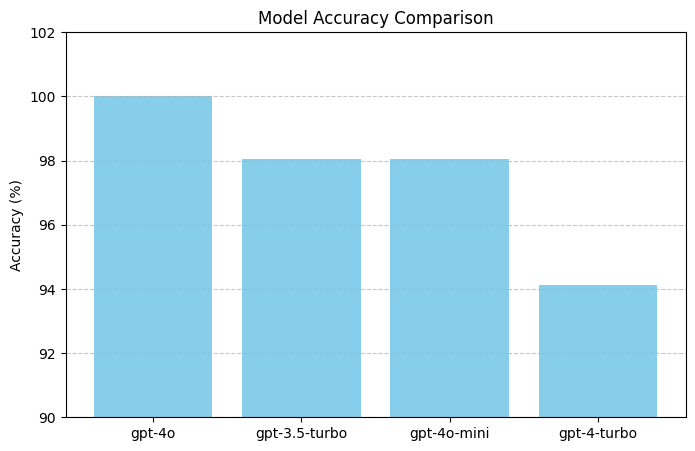

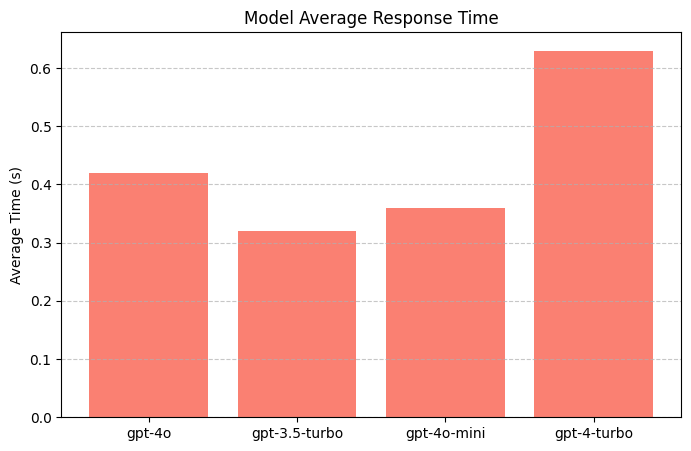

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
models = ['gpt-4o', 'gpt-3.5-turbo', 'gpt-4o-mini', 'gpt-4-turbo']
accuracy = [100.00, 98.04, 98.04, 94.12]
avg_time = [0.42, 0.32, 0.36, 0.63]

# Bar chart for Accuracy
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy, color='skyblue')
plt.ylim(90, 102)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar chart for Average Time
plt.figure(figsize=(8, 5))
plt.bar(models, avg_time, color='salmon')
plt.ylabel('Average Time (s)')
plt.title('Model Average Response Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()